# CS 247 Project Group 16

For this project, we implement a hybrid recommender system approach by training DeepFM on collaborative filtering techniques, along with item context vectors generated by Word2Vec and BERT.

In this notebook, we scrape movie plots, perform data preprocessing and exploration, and perform PCA to reduce dimensionality of the generated embeddings.

# Import necessary libraries

In [ ]:
!pip install wikipedia

  Preparing metadata (setup.py) ... done
  Created wheel for wikipedia: filename=wikipedia-1.4.0-py3-none-any.whl size=11678 sha256=28ae2ae896f69f8b8f2511e34ed25b620ea44668f42b596901b9e1504aeee314
  Stored in directory: /root/.cache/pip/wheels/5e/b6/c5/93f3dec388ae76edc830cb42901bb0232504dfc0df02fc50de
Successfully built wikipedia


In [1]:
#import necessary libraries
import numpy as np
import pandas as pd
import re
import os
import heapq
#import wikipedia
from tqdm.auto import tqdm
import nltk
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
from nltk import PorterStemmer
ps = PorterStemmer()
nltk.download('punkt')
import matplotlib.pyplot as plt
import matplotlib

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [2]:
#namrata's google drive path
from google.colab import drive
drive.mount('/content/drive')
path = "drive/MyDrive/CS 247 Project/ml-1m"


Mounted at /content/drive


Here, we load the ratings dataset from the MovieLens 1M dataset.

In [3]:
ratings = pd.read_csv(path + "/ratings.dat", sep="::" ,usecols = [0, 1, 2], names = ['user_id', 'movie_id', 'rating'])
#movies = pd.read_csv(path + "/movies.dat", sep="::", names = ['movie_id', 'title', 'genres'], encoding='latin-1')

<ipython-input-3-247c59e42d46>:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  ratings = pd.read_csv(path + "/ratings.dat", sep="::" ,usecols = [0, 1, 2], names = ['user_id', 'movie_id', 'rating'])


In [4]:
ratings.head()


,user_id,movie_id,rating
0,1,1193,5
1,1,661,3
2,1,914,3
3,1,3408,4
4,1,2355,5


Next, we scrape movie plots from wikipedia. Since we have this information in a csv file already, we simply read from the csv file.

In [5]:
#get the movie plots and concatenate them to the items dataset

def get_wikipedia_page_name(raw_name):
    print(raw_name)
    names = wikipedia.search(raw_name)
    if len(names) == 0:
      return ''
    else:
      return names[0]

def get_movie_plot(raw_name):
    names = wikipedia.search(raw_name)
    if len(names) == 0:
      page_name= ''
    else:
      page_name = names[0]
    print(page_name)

    try:
      try:
        movie_page_content = str(wikipedia.page(page_name, auto_suggest=False).content)
      except wikipedia.DisambiguationError as e:
        for option in e.options:
          if 'film' in option:
            movie_page_content = str(wikipedia.page(option, auto_suggest=False).content)
        return ''
    except (wikipedia.PageError, KeyError):
      return ''
    re_groups = re.search("Plot ==(.*?)=+ [A-Z]", str(movie_page_content).replace('\n', ''))
    if re_groups:
      return re_groups.group(1)
    else:
      return ''


#items['wikipedia_page_name'] = items['movie title'].apply(lambda name: get_wikipedia_page_name(name))
i = 0
name = path + '/1M_plot.csv'
if os.path.exists(name):
  movies_df = pd.read_csv(name)
else:
  movies['movie_plot'] = movies['title'].apply(lambda name: get_movie_plot(name))
  #movies[['movie title', 'movie_plot']].head()
  movies.to_csv(name)

# Exploratory Data Analysis

In this section, we explore the data and find out stats about it.

In [23]:
#number of users in the ratings table and number of movies

print("Number of users who have rated movies: " , len(set(ratings['user_id'])))
print("Number of movies: " , len(movies_df))

Number of users who have rated movies:  6040
Number of movies:  3157


In [8]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 3 columns):
 #   Column    Non-Null Count    Dtype
---  ------    --------------    -----
 0   user_id   1000209 non-null  int64
 1   movie_id  1000209 non-null  int64
 2   rating    1000209 non-null  int64
dtypes: int64(3)
memory usage: 22.9 MB


In [10]:
ratings.describe()

,user_id,movie_id,rating
count,1.000209e+06,1.000209e+06,1.000209e+06
mean,3.024512e+03,1.865540e+03,3.581564e+00
std,1.728413e+03,1.096041e+03,1.117102e+00
min,1.000000e+00,1.000000e+00,1.000000e+00
25%,1.506000e+03,1.030000e+03,3.000000e+00
50%,3.070000e+03,1.835000e+03,4.000000e+00
75%,4.476000e+03,2.770000e+03,4.000000e+00
max,6.040000e+03,3.952000e+03,5.000000e+00


In [9]:
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3883 entries, 0 to 3882
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  3883 non-null   int64 
 1   movie_id    3883 non-null   int64 
 2   title       3883 non-null   object
 3   genres      3883 non-null   object
 4   movie_plot  3157 non-null   object
dtypes: int64(2), object(3)
memory usage: 151.8+ KB


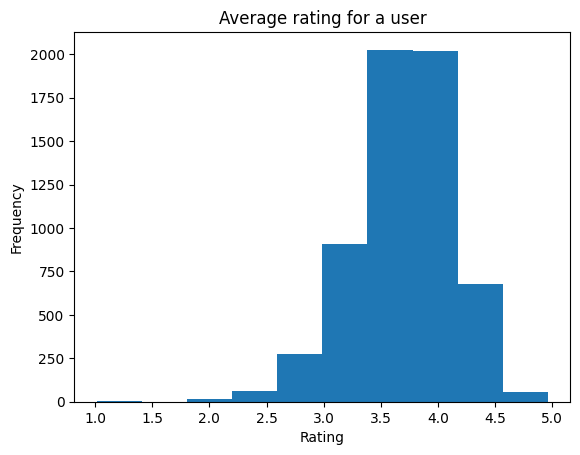

In [11]:
#Plot the average rating for a user

avg_user = ratings.groupby("user_id").mean()['rating']
plt.hist(avg_user)
plt.title("Average rating for a user")
plt.xlabel('Rating')
plt.ylabel("Frequency")
plt.show()

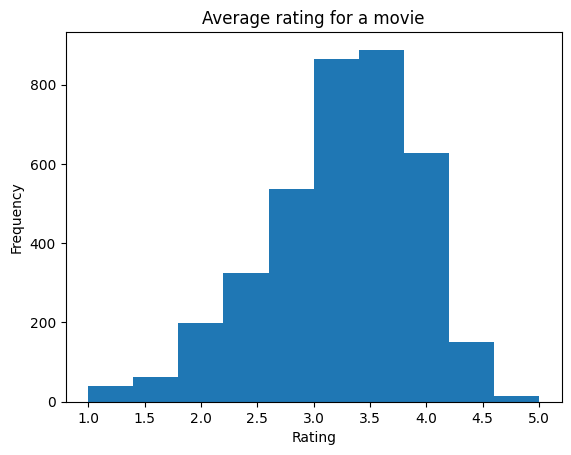

In [12]:
#Plot the average rating for a movie

avg_movie = ratings.groupby("movie_id").mean()['rating']
plt.hist(avg_movie)
plt.title("Average rating for a movie")
plt.xlabel('Rating')
plt.ylabel("Frequency")
plt.show()

# Data preprocessing

In this section, we process our data by removing null values and applying text processing techniques on the movie plots. We also combine the movie genres with the movie plots to form keywords for a movie.

In [13]:
#Find null values

movies_df["movie_plot"].isna().sum(), movies_df.shape


(726, (3883, 5))

In [14]:
#drop movies that have NaN plots. Remove those movie ratings from ratings matrix too

movies_df = movies_df[~pd.isna(movies_df['movie_plot'])]
ratings = ratings[ratings['movie_id'].isin(movies_df['movie_id'])]


In [15]:
movies_df["movie_plot"].isna().sum(), movies_df.shape


(0, (3157, 5))

In [16]:
ratings.shape

(922725, 3)

In [17]:
#Assign inner ids to get continuous movie ids

index = [i for i in range(movies_df.shape[0])]
movies_df.index = index

In [18]:
movies_df

,Unnamed: 0,movie_id,title,genres,movie_plot
0,0,1,Toy Story (1995),Animation|Children's|Comedy,"Sentient when humans are not around, a group o..."
1,1,2,Jumanji (1995),Adventure|Children's|Fantasy,"In 1969, Alan Parrish lives in Brantford, New ..."
2,2,3,Grumpier Old Men (1995),Comedy|Romance,The feud between Max and John has cooled and t...
3,3,4,Waiting to Exhale (1995),Comedy|Drama,"Four friends (Savannah, Robin, Bernadine, and ..."
4,4,5,Father of the Bride Part II (1995),Comedy,"Four years after the events of the first film,..."
...,...,...,...,...,...
3152,3878,3948,Meet the Parents (2000),Comedy,"Greg Focker, a Jewish American nurse living in..."
3153,3879,3949,Requiem for a Dream (2000),Drama,"Sara Goldfarb, a widow who lives alone in a Br..."
3154,3880,3950,Tigerland (2000),Drama,"In September 1971, the United States is losing..."
3155,3881,3951,Two Family House (2000),Drama,An unseen narrator looks back to the year 1956...


In [20]:
#split genres into individual words

#convert to numpy array
for i in range(movies_df.shape[0]):
  genres = movies_df.iloc[i]['genres']
  movies_df.at[i, 'genres'] = ' '.join(genres.split("|"))

In [19]:
movies_df.isna().sum()

Unnamed: 0    0
movie_id      0
title         0
genres        0
movie_plot    0
dtype: int64

In [ ]:
#preprocess the plots

def preprocess_sentences(sentence):
  text = str(sentence).lower()
  temp_sent =[]
  words = nltk.word_tokenize(text)
  for word in words:
    if word not in stop_words and word.isalpha():
        temp_sent.append(word)

  stemmed = [ps.stem(word) for word in temp_sent]
  stemmed = " ".join(stemmed)
  return stemmed

movies_df['processed_plot'] = movies_df['movie_plot'].apply(preprocess_sentences)
#construct tags column
movies_df['keywords'] = movies_df['genres'] + " " + movies_df['processed_plot']
movies_df.head()

,Unnamed: 0,movie_id,title,genres,movie_plot,processed_plot,keywords
0,0,1,Toy Story (1995),Animation Children's Comedy,"Sentient when humans are not around, a group o...",sentient human around group toy prepar move ne...,Animation Children's Comedy sentient human aro...
1,1,2,Jumanji (1995),Adventure Children's Fantasy,"In 1969, Alan Parrish lives in Brantford, New ...",alan parrish live brantford new hampshir paren...,Adventure Children's Fantasy alan parrish live...
2,2,3,Grumpier Old Men (1995),Comedy Romance,The feud between Max and John has cooled and t...,feud max john cool becom good friend children ...,Comedy Romance feud max john cool becom good f...
3,3,4,Waiting to Exhale (1995),Comedy Drama,"Four friends (Savannah, Robin, Bernadine, and ...",four friend savannah robin bernadin gloria get...,Comedy Drama four friend savannah robin bernad...
4,4,5,Father of the Bride Part II (1995),Comedy,"Four years after the events of the first film,...",four year event first film anni bank tell fami...,Comedy four year event first film anni bank te...


In [ ]:
#convert to csv file for easy future processing

movies_df.to_csv("drive/My Drive/CS 247 Project/1M_movies_with_plots.csv")

# Word2Vec embeddings generation

In this section, we generate the Word2Vec embeddings for each movie's keywords. We will then save it to a file.



In [ ]:
#read in movies_df with keywords

movies_df = pd.read_csv("drive/My Drive/CS 247 Project/1M_movies_with_plots.csv")

In [ ]:
movies_df.shape

(3157, 7)

In [ ]:
#Perform Word2Vec embedding generation

import pandas as pd
import numpy as np
from gensim.models import Word2Vec, KeyedVectors
from gensim.utils import simple_preprocess
from sklearn.metrics.pairwise import cosine_similarity
import gensim.downloader as api


# Fill missing values in the 'keywords' column
movies_df['keywords'].fillna('', inplace=True)

# Tokenize content for Word2Vec
movies_df['tokenized_content'] = movies_df['keywords'].apply(lambda x: simple_preprocess(x) if isinstance(x, str) else [])

# Load the pre-trained Word2Vec model (Google News)
model = api.load('word2vec-google-news-300')

# Function to average word vectors for a text
def average_word_vectors(words, model, vocabulary, num_features):
    feature_vector = np.zeros((num_features,), dtype="float64")
    nwords = 0.

    for word in words:
        if word in vocabulary:
            nwords = nwords + 1.
            feature_vector = np.add(feature_vector, model[word])

    if nwords:
        feature_vector = np.divide(feature_vector, nwords)

    return feature_vector

# Function to compute average word vectors for all movies
def averaged_word_vectorizer(corpus, model, num_features):
    vocabulary = set(model.index_to_key)
    features = [average_word_vectors(tokenized_sentence, model, vocabulary, num_features) for tokenized_sentence in corpus]
    return np.array(features)

# Compute average word vectors for all movies
w2v_feature_array = averaged_word_vectorizer(corpus=movies_df['tokenized_content'], model=model, num_features=300)

# Create a dictionary to map movie titles to their indices
title_to_index = {title: i for i, title in enumerate(movies_df['movie title'])}


print(title_to_index['Toy Story (1995)'])  # This will print the index of the movie 'Toy Story (1995)'


In [ ]:
#Save the embeddings to a csv file

print(w2v_feature_array.shape)
w2v = pd.DataFrame(w2v_feature_array)
w2v.head()
w2v.to_csv("drive/MyDrive/CS 247 Project/1M_w2v_original_300.csv")

(3157, 300)


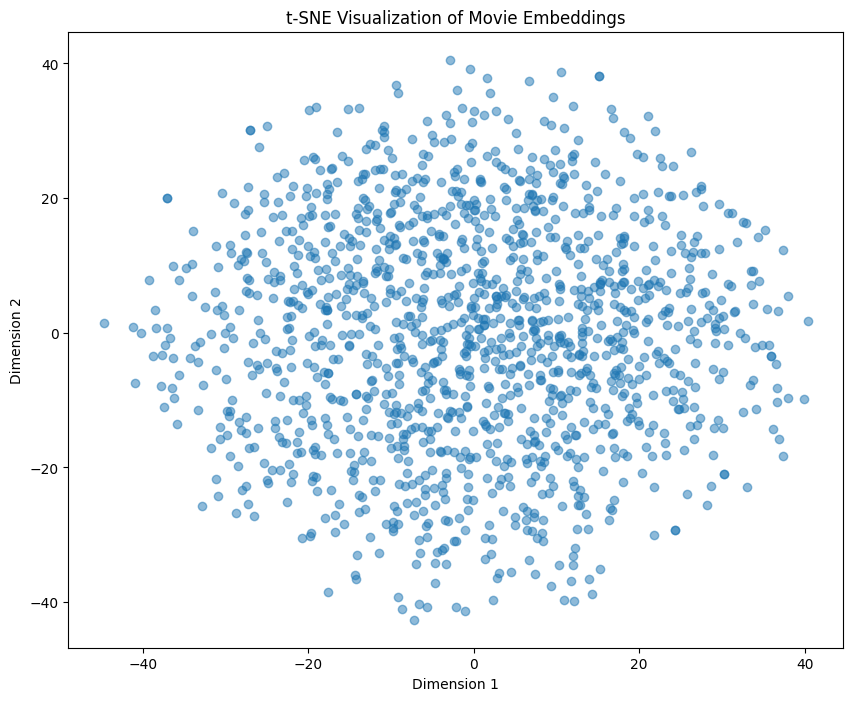

In [ ]:
#Visualize embeddings

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=3, random_state=42)
embeddings_2d = tsne.fit_transform(w2v_feature_array)

# Plot the embeddings
plt.figure(figsize=(10, 8))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], alpha=0.5)
plt.title('t-SNE Visualization of Movie Embeddings')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()


# Principal Component Analysis
To reduce embedding dimensionality, we perform PCA on the embeddings generated by Word2Vec and BERT.

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [ ]:
movies_df.shape

(3157, 8)

In [ ]:
#IMPORTANT: add movie_inner_id as unique id column

arr = np.array([i for i in range(len(movies_df))])
movies_df['movie_inner_id'] = arr
movies_df.head()

,Unnamed: 0,movie_id,title,genres,movie_plot,processed_plot,keywords,movie_inner_id
0,0,1,Toy Story (1995),Animation Children's Comedy,"Sentient when humans are not around, a group o...",sentient human around group toy prepar move ne...,Animation Children's Comedy sentient human aro...,0
1,1,2,Jumanji (1995),Adventure Children's Fantasy,"In 1969, Alan Parrish lives in Brantford, New ...",alan parrish live brantford new hampshir paren...,Adventure Children's Fantasy alan parrish live...,1
2,2,3,Grumpier Old Men (1995),Comedy Romance,The feud between Max and John has cooled and t...,feud max john cool becom good friend children ...,Comedy Romance feud max john cool becom good f...,2
3,3,4,Waiting to Exhale (1995),Comedy Drama,"Four friends (Savannah, Robin, Bernadine, and ...",four friend savannah robin bernadin gloria get...,Comedy Drama four friend savannah robin bernad...,3
4,4,5,Father of the Bride Part II (1995),Comedy,"Four years after the events of the first film,...",four year event first film anni bank tell fami...,Comedy four year event first film anni bank te...,4


Word2Vec PCA

In [ ]:
#Load in the saved word2Vec embeddings

w2v_embeds = pd.read_csv("drive/MyDrive/CS 247 Project/1M_w2v_original_300.csv")
w2v_embeds = w2v_embeds.drop(columns=['Unnamed: 0'])
print(w2v_embeds.shape)
w2v_embeds.head()

(3157, 301)


,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,290,291,292,293,294,295,296,297,298,299
0,0,0.032301,0.047896,-0.005542,0.043634,-0.049701,-0.055790,0.014574,-0.079791,0.059221,...,-0.034961,0.070178,-0.082803,-0.002887,-0.001610,-0.059758,-0.032339,-0.023502,-0.025756,-0.001828
1,1,-0.006844,0.035722,-0.025817,0.081226,0.002044,-0.016105,0.005059,-0.087781,0.061394,...,0.012748,0.048682,-0.054588,0.027230,-0.015941,-0.071135,-0.037520,-0.064142,-0.011860,0.009938
2,2,-0.008875,0.026432,-0.012406,0.109595,-0.059711,-0.002991,-0.000822,-0.081909,0.080318,...,0.014551,0.098647,-0.113200,-0.015852,-0.049402,-0.053999,-0.050551,-0.056378,0.003340,0.008520
3,3,0.009851,0.020416,-0.012724,0.087836,-0.030948,0.030955,0.019729,-0.071846,0.050815,...,-0.011353,0.086162,-0.085487,-0.033041,-0.042582,-0.043318,-0.020427,-0.043764,0.002703,0.016894
4,4,-0.000295,0.024032,-0.003898,0.077296,-0.047054,0.004741,0.041642,-0.073367,0.082786,...,-0.001484,0.084617,-0.093910,0.003088,-0.024927,-0.046737,-0.055277,-0.033767,0.023539,0.027952


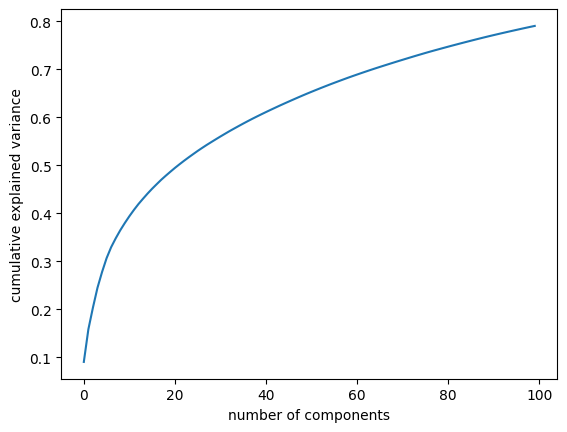

In [ ]:
#PCA for Word2Vec

pca_w2v = PCA(n_components=100)
reduced_w2v = pca_w2v.fit_transform(w2v_embeds)

#visualise the explained variance ratio

plt.plot(np.cumsum(pca_w2v.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [ ]:
#Save the reduced embeddings to a file

reduced_w2v = pd.DataFrame(reduced_w2v)
reduced_w2v.to_csv("drive/MyDrive/CS 247 Project/1M_reduced_w2v_100.csv")
reduced_w2v.head(), reduced_w2v.shape


(         0         1         2         3         4         5         6   \
 0 -0.058674 -0.085608 -0.038852 -0.061552 -0.117980  0.096884  0.034158   
 1  0.194539 -0.080602 -0.024736 -0.088577 -0.042103  0.038160 -0.016469   
 2  0.125672 -0.019743 -0.089809 -0.071626 -0.070942  0.075360 -0.016630   
 3  0.035269  0.138111 -0.009291  0.049920 -0.045270 -0.049855 -0.035840   
 4  0.047582  0.107250 -0.023825 -0.073738  0.000323 -0.065566 -0.032026   
 
          7         8         9   ...        90        91        92        93  \
 0 -0.025086  0.028278 -0.103825  ...  0.005071 -0.025791 -0.006914  0.032553   
 1 -0.001388 -0.026398  0.004865  ...  0.027939  0.014033 -0.005270 -0.024265   
 2 -0.042018 -0.032069  0.011514  ... -0.046452  0.005076  0.001770  0.008272   
 3 -0.017260  0.017124 -0.026674  ... -0.001618  0.026371 -0.022579 -0.022379   
 4 -0.031739  0.066482  0.012636  ... -0.021506 -0.001820  0.014947  0.011778   
 
          94        95        96        97        98  

In [ ]:
#Add the inner movie id and save it as a separate file to offer easier lookup during training

reduced_embeds = reduced_w2v

arr = np.array([i for i in range(len(movies_df))])
reduced_embeds['movie_inner_id'] = arr
cols = reduced_embeds.columns.tolist()
cols = cols[-1:] + cols[:-1]
reduced_embeds = reduced_embeds[cols]

reduced_embeds.to_csv("drive/MyDrive/CS 247 Project/1M_movieid_w2v_100.csv")

In [ ]:
reduced_embeds.shape, reduced_embeds.head()

((3157, 101),
    movie_inner_id         0         1         2         3         4         5  \
 0               0 -0.058674 -0.085608 -0.038852 -0.061552 -0.117980  0.096884   
 1               1  0.194539 -0.080602 -0.024736 -0.088577 -0.042103  0.038160   
 2               2  0.125672 -0.019743 -0.089809 -0.071626 -0.070942  0.075360   
 3               3  0.035269  0.138111 -0.009291  0.049920 -0.045270 -0.049855   
 4               4  0.047582  0.107250 -0.023825 -0.073738  0.000323 -0.065566   
 
           6         7         8  ...        90        91        92        93  \
 0  0.034158 -0.025086  0.028278  ...  0.005071 -0.025791 -0.006914  0.032553   
 1 -0.016469 -0.001388 -0.026398  ...  0.027939  0.014033 -0.005270 -0.024265   
 2 -0.016630 -0.042018 -0.032069  ... -0.046452  0.005076  0.001770  0.008272   
 3 -0.035840 -0.017260  0.017124  ... -0.001618  0.026371 -0.022579 -0.022379   
 4 -0.032026 -0.031739  0.066482  ... -0.021506 -0.001820  0.014947  0.011778   
 
    

BERT PCA

Now, we perform PCA on the BERT embeddings.

In [ ]:
folder_path = "drive/MyDrive/CS 247 Project/10th_March_BERT_movie_embeddings.csv"
bert_embeddings = pd.read_csv(folder_path, header=None)
bert_embeddings.head()

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,-0.354938,0.055294,0.535662,0.016911,0.257760,-0.031973,0.036531,-0.045506,-0.099130,-0.229953,...,-0.390960,-0.341942,0.103260,0.160311,0.009635,0.003835,-0.624504,-0.005162,0.161328,-0.002070
1,-0.350013,-0.047078,0.474593,-0.066661,0.460981,-0.058233,0.155333,0.111255,-0.017857,-0.250210,...,-0.397488,-0.213463,0.094989,0.061074,0.026851,-0.179708,-0.546885,-0.108441,0.050433,0.146390
2,-0.021004,-0.077059,0.325559,0.195044,0.044663,0.007157,-0.012687,0.014451,0.020503,0.077981,...,0.020842,-0.126572,0.153138,-0.059947,0.094046,0.117395,0.009193,0.127859,0.134761,0.164424
3,0.032292,-0.029772,0.567799,-0.175749,0.454340,-0.003125,0.005940,0.011646,0.101402,-0.309613,...,-0.364782,-0.450121,0.135068,0.172036,-0.117097,0.011439,-0.707874,-0.096183,-0.042957,-0.095156
4,-0.362471,0.036806,0.513014,-0.122374,0.360396,0.076607,0.121204,-0.021013,-0.003072,-0.299811,...,-0.401280,-0.321970,0.053093,0.139898,-0.210887,0.088246,-0.433998,-0.141566,-0.008733,0.028656


In [ ]:
len(bert_embeddings)

1372

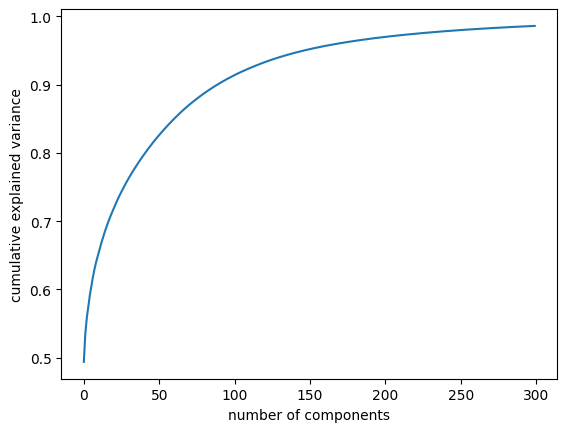

In [ ]:
#pca for bert

pca_bert = PCA(n_components=300)
reduced_embs = pca_bert.fit_transform(bert_embeddings)

#visualise the explained variance ratio

plt.plot(np.cumsum(pca_bert.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [ ]:
reduced_embeddings = pd.DataFrame(reduced_embs)

In [ ]:
reduced_embeddings.head(), reduced_embeddings.shape

(        0         1         2         3         4         5         6    \
 0 -0.832738 -0.215074  0.347622 -0.637940  0.749081 -0.349148  0.056785   
 1 -1.341698  1.629674  0.042430  0.086045 -0.129394 -0.555819  0.706938   
 2  5.429399  1.385329 -0.097708 -0.076707  1.319640 -0.118385 -0.096060   
 3 -1.424625 -0.833726  1.036436  0.355735  0.291084 -0.359851 -0.231848   
 4 -0.312232  0.339018  0.604763  0.400713 -0.615663  0.020199  0.088661   
 
         7         8         9    ...       290       291       292       293  \
 0  0.167086 -0.703274  0.452534  ...  0.035519 -0.020190  0.014588 -0.050765   
 1  0.050253  0.323971  0.018559  ...  0.013141 -0.044769  0.037007 -0.021662   
 2  1.056974 -0.762405  0.200421  ...  0.001075 -0.015087 -0.052423 -0.051647   
 3  0.540400 -0.508264  0.495955  ... -0.060226  0.052180 -0.011440  0.022730   
 4 -0.072559 -0.544776 -0.041252  ...  0.010882 -0.006909  0.015252 -0.004810   
 
         294       295       296       297       298  

In [ ]:
#save only the embedding vectors to a file

reduced_embeddings.to_csv("drive/MyDrive/CS 247 Project/reduced_bert_100.csv")

In [ ]:
reduced_embeddings.shape, movies_df.shape

((1372, 300), (1372, 28))

In [ ]:
#save the embeddings along with the movie_id for easier lookup

#reduced_embeds = pd.read_csv("drive/MyDrive/CS 247 Project/reduced_bert.csv")
reduced_embeds = reduced_embeddings

arr = np.array([i for i in range(len(movies_df))])
reduced_embeds['movie_inner_id'] = arr
cols = reduced_embeds.columns.tolist()
cols = cols[-1:] + cols[:-1]
reduced_embeds = reduced_embeds[cols]

reduced_embeds.to_csv("drive/MyDrive/CS 247 Project/movieid_bert_100.csv")

In [ ]:
reduced_embeds


,movie_inner_id,0,1,2,3,4,5,6,7,8,...,290,291,292,293,294,295,296,297,298,299
0,0,-0.832738,-0.215074,0.347622,-0.637940,0.749081,-0.349148,0.056785,0.167086,-0.703274,...,0.035519,-0.020190,0.014588,-0.050765,0.036667,-0.033171,0.001195,-0.018493,-0.002712,-0.025460
1,1,-1.341698,1.629674,0.042430,0.086045,-0.129394,-0.555819,0.706938,0.050253,0.323971,...,0.013141,-0.044769,0.037007,-0.021662,0.039157,-0.004886,-0.013238,0.009502,0.024327,0.020551
2,2,5.429399,1.385329,-0.097708,-0.076707,1.319640,-0.118385,-0.096060,1.056974,-0.762405,...,0.001075,-0.015087,-0.052423,-0.051647,-0.046060,0.022055,0.062438,-0.026410,-0.014263,-0.034665
3,3,-1.424625,-0.833726,1.036436,0.355735,0.291084,-0.359851,-0.231848,0.540400,-0.508264,...,-0.060226,0.052180,-0.011440,0.022730,-0.020972,0.018542,0.109261,0.019409,0.033502,0.037364
4,4,-0.312232,0.339018,0.604763,0.400713,-0.615663,0.020199,0.088661,-0.072559,-0.544776,...,0.010882,-0.006909,0.015252,-0.004810,-0.031749,-0.010764,0.007000,-0.009742,-0.047384,-0.020260
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1367,1367,0.676591,0.265226,0.244031,-0.519665,0.040395,0.059998,0.042063,-0.140188,0.171902,...,-0.049289,-0.013630,0.018558,0.003654,0.021049,0.002258,-0.003421,0.011062,0.042565,-0.000883
1368,1368,4.058698,-0.408721,0.108924,0.022884,-0.312680,-0.462640,0.083774,-0.291438,0.307971,...,0.021136,0.032635,0.057617,-0.059884,0.049423,-0.040301,0.016656,-0.013707,0.021790,0.036390
1369,1369,3.289943,-0.354229,-0.554306,-0.752881,-0.385706,0.945230,0.543655,-0.039310,-0.088156,...,0.025665,0.005987,0.026190,-0.035468,0.041427,-0.045517,-0.043930,0.015257,0.040378,0.002937
1370,1370,4.790489,0.810977,0.161456,-0.008983,0.306331,0.037846,-0.302907,0.188807,-0.542763,...,0.021300,0.002599,0.058985,0.000044,-0.031526,-0.012970,0.037504,0.032796,-0.074105,0.024648


DeepFM attempt

In [ ]:
movies_df = movies_df.rename(columns={"movie id": "movie_id"})
movies_df.head(1)


,Unnamed: 0,movie_id,movie title,release date,unknown,Action,Adventure,Animation,Children's,Comedy,...,Romance,Sci-Fi,Thriller,War,Western,movie_plot,genres,processed_plot,keywords,movie_inner_id
0,0,1,Toy Story (1995),1995,0,0,0,1,1,1,...,0,0,0,0,0,"Sentient when humans are not around, a group o...",Animation Children's Comedy,sentient human around group toy prepar move ne...,1995 Animation Children's Comedy sentient huma...,0


In [ ]:
movies_df.shape

(3157, 9)

In [ ]:
#merge
result = pd.merge(ratings, movies_df, on="movie_id", how="left")


In [ ]:
ratings.shape
#ratings = ratings.drop(columns=['unix_timestamp'])

(922725, 3)

In [ ]:
result = result[['user_id', 'movie_inner_id', 'rating']]

In [ ]:
result.head()

,user_id,movie_inner_id,rating
0,1,916,5
1,1,526,3
2,1,700,3
3,1,1844,5
4,1,999,5


In [ ]:
result.shape, ratings.shape

((922725, 3), (922725, 3))

In [ ]:
result.head(6)

,user_id,movie_inner_id,rating
0,1,916,5
1,1,526,3
2,1,700,3
3,1,1844,5
4,1,999,5
5,1,2217,5


In [ ]:
movies_df.shape

(3157, 9)

In [ ]:
result.head(6)


,user_id,movie_inner_id,rating
0,1,916,5
1,1,526,3
2,1,700,3
3,1,1844,5
4,1,999,5
5,1,2217,5


In [ ]:
result[result['movie_inner_id'].isna()]

,user_id,movie_inner_id,rating


In [ ]:
result.isna().sum()

user_id           0
movie_inner_id    0
rating            0
dtype: int64

In [ ]:
#merge ratings with embeddings on movie_inner_id
ratings_embeds = pd.merge(result, reduced_embeds, on="movie_inner_id", how="left")

In [ ]:
ratings_embeds.head()

,user_id,movie_inner_id,rating,0,1,2,3,4,5,6,...,90,91,92,93,94,95,96,97,98,99
0,1,916,5,-0.120457,-0.007396,-0.047148,-0.029241,0.062184,-0.117273,0.018916,...,0.016862,0.015250,-0.010302,-0.002097,-0.009124,-0.031221,0.009206,0.009325,0.006662,-0.000506
1,1,526,3,-0.128856,0.013362,-0.014911,0.078844,-0.193645,0.079219,-0.059889,...,-0.002904,-0.008790,0.015202,-0.020515,0.018819,-0.006338,-0.014614,-0.004875,-0.037311,-0.017957
2,1,700,3,-0.074859,0.118441,-0.035943,-0.067123,-0.007490,-0.063511,0.024411,...,0.001636,-0.014686,-0.004647,-0.023234,-0.009597,-0.013372,0.020578,0.012320,-0.007085,-0.000279
3,1,1844,5,-0.099868,-0.144381,0.019822,-0.023104,-0.190232,0.029021,0.041410,...,0.003398,-0.030757,-0.008782,0.010552,0.011781,-0.031856,-0.007878,0.023878,-0.018430,0.028598
4,1,999,5,-0.070592,-0.014238,0.080779,0.062785,-0.030660,-0.098605,-0.051405,...,-0.002560,-0.007126,-0.001201,0.002005,0.002988,-0.004120,0.022128,-0.007264,0.010523,-0.015773


In [ ]:
ratings_embeds.shape

(922725, 103)

In [ ]:
any(ratings_embeds.isna().sum())

False